In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 25 19:08:22 2019

@author: 86134
"""

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import Annotation_parser
import skimage.io
import glob

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
# Dateset Information
length_of_dataset = 1
num_data_train = 0
num_data_val = 1

class TrashConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "trash"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)# anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = TrashConfig()
config.display()

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class TrashDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of 
    (battery, ring-pull can) 
    """
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        load instance masks and return them in the form of an
        array of binary masks of shape [height, width, instances].

        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        handler = self.image_info[image_id]["handler"]
        mask = np.zeros([handler.height, handler.width, len(handler.object)], dtype=np.uint8)
        class_ids = np.zeros([len(handler.object)], dtype = np.uint8)
        info = self.image_info[image_id]
        handler = info["handler"]
        for i in range(len(handler.object)):
            for basic_class in self.class_info:
                if basic_class["name"] == handler.object[i].name:
                    class_ids[i] = basic_class["id"]
            im = np.zeros([handler.height, handler.width], dtype=np.uint8)
            cv2.fillPoly(im, np.array([handler.object[i].polygon]), 1)
            mask[:, :, i] += im[:, :]
        return mask, class_ids


class InferenceConfig(TrashConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Using TensorFlow backend.



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [2]:
IMAGE_DIR = [path for path in glob.glob("./trash_image/*.jpg")]
image_list = []
for path in IMAGE_DIR:
    image = skimage.io.imread(path)
    image_list.append(image)
    #plt.imshow(image)
    #plt.show()

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
5.5361974239349365


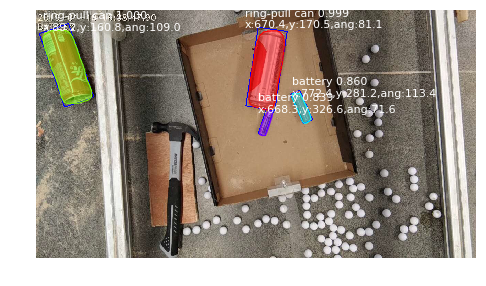

In [8]:
import time 
t = time.time()
image = image_list[210]
results = model.detect([image], verbose=1)
r = results[0]
visualize.locate_and_display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ["BG","battery","ring-pull can"], r['scores'], ax=get_ax())
t2 = time.time()
print(t2-t)